In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
import glob
import re

frames = []

for file in glob.glob('babynames/*.txt'):
    search = re.search('.*?(\d\d\d\d)\.txt', file)
    if search:
        year = int(search.group(1))
        frame = pd.read_csv(file, names=['name', 'sex', 'births'])
        frame['year'] = year
        frames.append(frame)

names = pd.concat(frames, ignore_index=True)

names.head(10)

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
5,Margaret,F,1578,1880
6,Ida,F,1472,1880
7,Alice,F,1414,1880
8,Bertha,F,1320,1880
9,Sarah,F,1288,1880


### Сгруппируйте данные по полу и году и визуализируйте общую динамику рождаемости обоих полов

In [3]:
total_births = names.pivot_table('births', index='year', columns='sex', aggfunc=sum)
total_births.head(5)

sex,F,M
year,,
1880,90993,110493
1881,91955,100748
1882,107851,113687
1883,112322,104632
1884,129021,114445


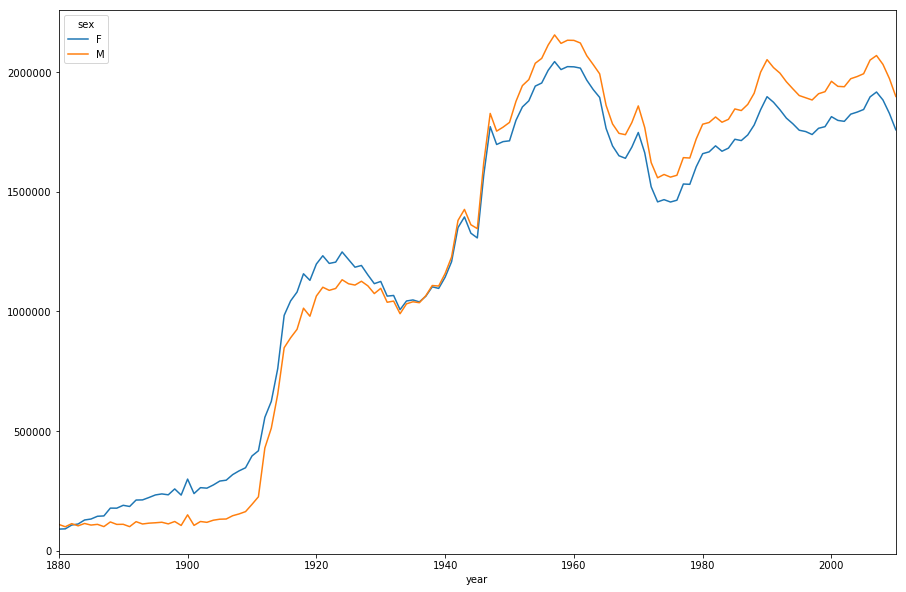

In [4]:
total_births.plot(figsize=(15, 10), legend=True);

### Найдите самые популярные имена за всю историю

In [5]:
names[names['sex'] == 'M'].pivot_table('births', index='name', aggfunc=sum) \
    .sort_values('births', ascending=False).head(5).reset_index()

,name,births
0,James,5049727
1,John,5040319
2,Robert,4767995
3,Michael,4243903
4,William,3986586


In [6]:
names[names['sex'] == 'F'].pivot_table('births', index='name', aggfunc=sum) \
    .sort_values('births', ascending=False).head(5).reset_index()

,name,births
0,Mary,4103935
1,Patricia,1568742
2,Elizabeth,1561874
3,Jennifer,1455078
4,Linda,1448771


### Разбейте весь временной промежуток в данных на 10 частей и для каждой найдите самое популярное имя каждого пола. Для каждого найденного имени визуализируйте его динамику за все время

In [7]:
splited_names = []
start_year = 1880
finish_year = 2010
step = (finish_year - start_year) / 10
while start_year < finish_year:
    splited_names.append(names[names['year'].between(start_year, start_year + step, inclusive=True)])
    start_year += step

In [8]:
def get_most_popular_names(df, sex, count=1):
    return df[df['sex'] == sex] \
        .groupby('name')['births'] \
        .sum() \
        .reset_index() \
        .sort_values('births', ascending=False) \
        .head(count) \
        .reset_index() \
        .name

#### Для начала построим график по мужским именам

John
John
John
Robert
Robert
James
Michael
Michael
Michael
Jacob


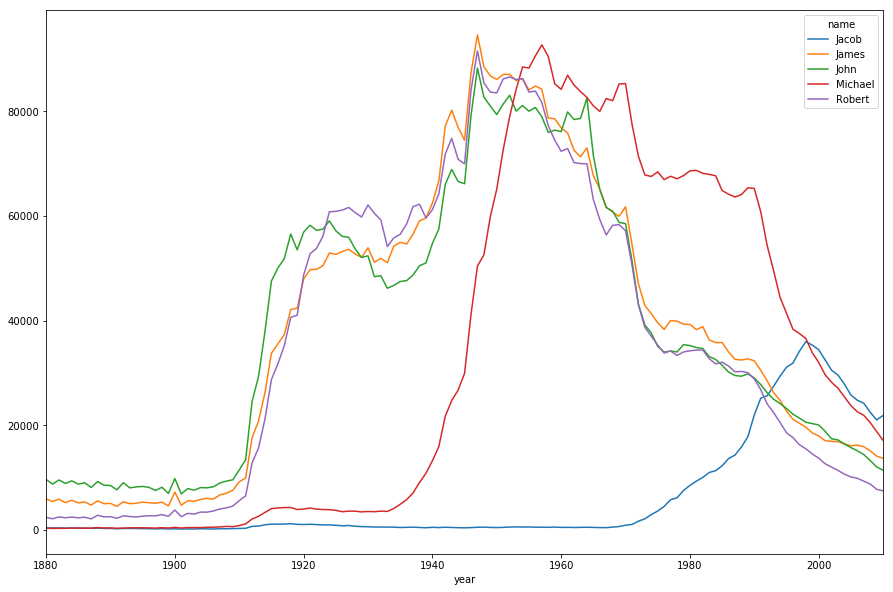

In [9]:
boys_names = []
for s_n in splited_names:
    boys_names.append(get_most_popular_names(s_n, 'M'))

for n in boys_names:
    print(n.item())

names[(names['sex'] == 'M') & (names['name'].isin(boys_names))] \
    .pivot_table('births', index='year', columns='name', aggfunc=sum) \
    .plot(figsize=(15, 10), legend=True);

#### Теперь построим график по женским именам

Mary
Mary
Mary
Mary
Mary
Mary
Lisa
Jennifer
Jessica
Emily


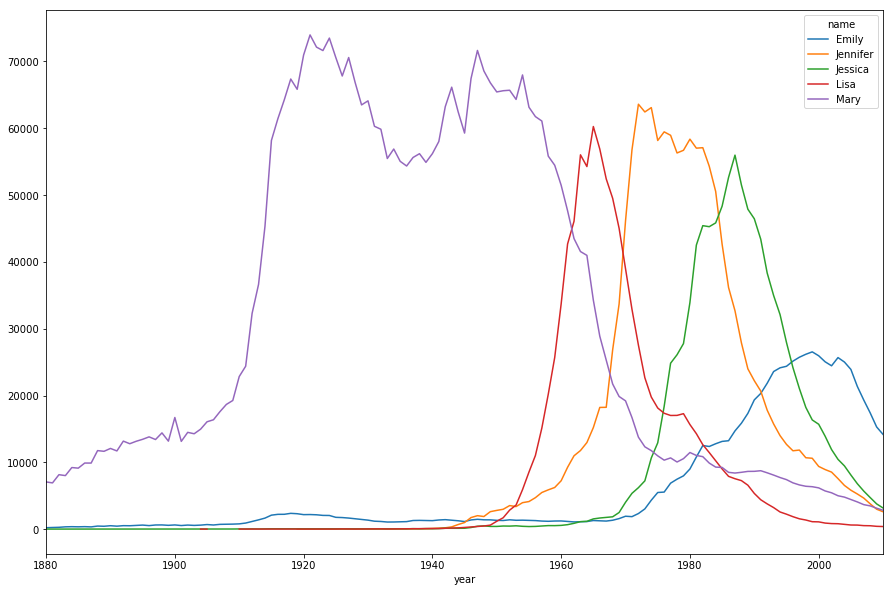

In [10]:
girls_names = []
for s_n in splited_names:
    girls_names.append(get_most_popular_names(s_n, 'F'))

for n in girls_names:
    print(n.item())
    
names[(names['sex'] == 'F') & (names['name'].isin(girls_names))] \
    .pivot_table('births', index='year', columns='name', aggfunc=sum) \
    .plot(figsize=(15, 10), legend=True);

### Для каждого года рассчитайте сколько имен покрывают 50% людей, визуализируйте (мы увидим разнообразие имен за каждый год)

In [11]:
frames = []

def add_percent(group):
    group['percent'] = group.births / (group.births.sum() / 100)
    return group

for file in glob.glob('babynames/*.txt'):
    search = re.search('.*?(\d\d\d\d)\.txt', file)
    if search:
        year = int(search.group(1))
        frame = pd.read_csv(file, names=['name', 'sex', 'births'])
        frame['year'] = year
        frame = frame.groupby(['year', 'sex']).apply(add_percent)
        frames.append(frame)

names_with_percent = pd.concat(frames, ignore_index=True)
names_with_percent.head(15)

,name,sex,births,year,percent
0,Mary,F,7065,1880,7.764334
1,Anna,F,2604,1880,2.861759
2,Emma,F,2003,1880,2.201268
3,Elizabeth,F,1939,1880,2.130933
4,Minnie,F,1746,1880,1.918829
5,Margaret,F,1578,1880,1.734199
6,Ida,F,1472,1880,1.617707
7,Alice,F,1414,1880,1.553966
8,Bertha,F,1320,1880,1.450661
9,Sarah,F,1288,1880,1.415493


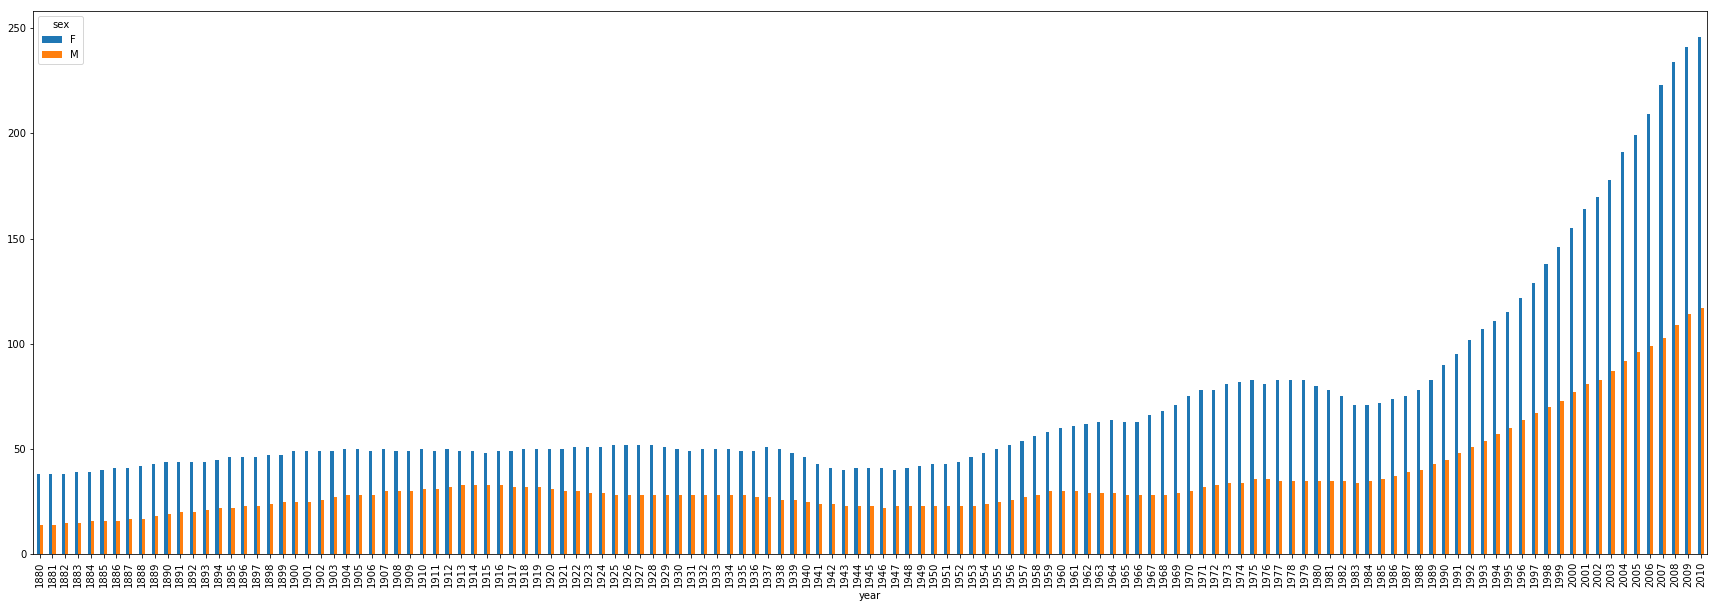

In [108]:
def get_quantile_count(group, q=50):
    group = group.sort_values(by='percent', ascending=False)
    return group.percent.cumsum().values.searchsorted(q) + 1

diversity = names_with_percent.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')
diversity.plot.bar(figsize=(30, 10), legend=True);

### Выберите 4 года из всего промежутка и отобразите для каждого года распределение по первой букве в имени, по последней букве в имени

In [47]:
years = [1880, 1920, 1960, 2000]

#### Для начала подготовим распределение по первой букве в имени

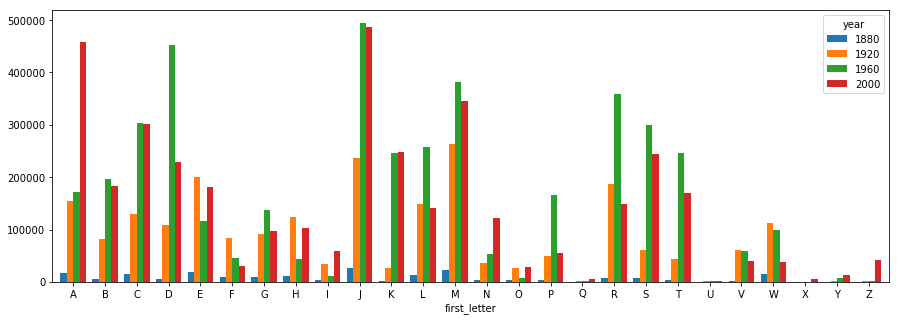

In [93]:
def get_first_letter(x):
    return x[0]

first_letters = names.name.map(get_first_letter)
first_letters.name = 'first_letter'

table_first = names[names['year'].isin(years)] \
    .pivot_table('births', index=first_letters, columns='year', aggfunc=sum)
table_first.plot(figsize=(15, 5), kind='bar', rot=0, width=0.8);

#### Теперь сделаем распределение по последней букве имени

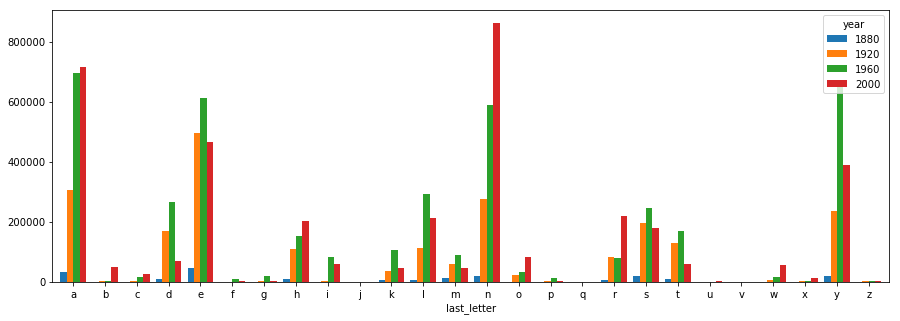

In [94]:
def get_last_letter(x):
    return x[-1]

last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table_last = names[names['year'].isin(years)] \
    .pivot_table('births', index=last_letters, columns='year', aggfunc=sum)
table_last.plot(figsize=(15, 5), kind='bar', rot=0, width=0.8);

### Составьте список из нескольких известных людей (президенты, певцы, актеры, киногерои) и оцените их влияние на динамику имен, постройте наглядную визуализацию

#### Возьмем следующих популярных исполнителей:
1. Marilyn Monroe - род. 1926г., годы творческой активности 1945 - 1962
2. Elvis Presley - род. 1935г., годы творческой активности 1954 - 1977
3. Tina Turner - род. 1939г., годы творческой активности 1958 - н.в.
4. Freddie Mercury - род. 1946г., годы творческой активности 1969 — 1991

#### Для анализа возьмем промежуток времени в 100 лет с 1900 по 2000 годы

In [103]:
famous_names = ['Marilyn', 'Elvis', 'Tina', 'Freddie']
start_year = 1900
finish_year = 2000

famous_df = names[
    (names['year'].between(start_year, finish_year, inclusive=True)) & names['name'].isin(famous_names)
]
famous_df.head(10)

,name,sex,births,year
52731,Tina,F,53,1900
52859,Freddie,F,35,1900
53413,Marilyn,F,12,1900
54747,Freddie,M,63,1900
55479,Elvis,M,8,1900
56432,Tina,F,47,1901
56634,Freddie,F,25,1901
57593,Marilyn,F,6,1901
58283,Freddie,M,29,1901
58826,Elvis,M,7,1901


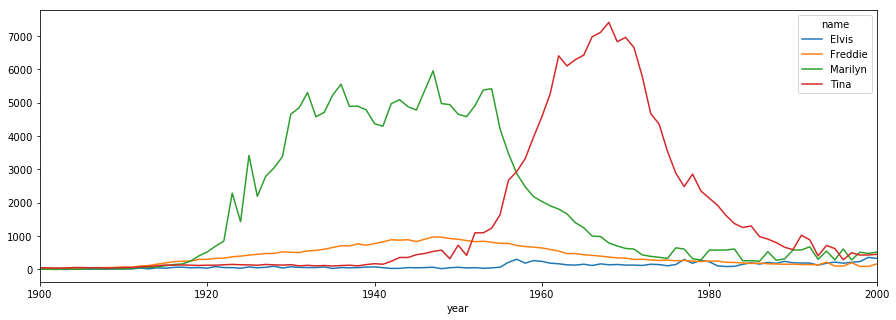

In [112]:
famous_table = famous_df.pivot_table('births', index='year', columns='name').fillna(0)
famous_table.plot(figsize=(15, 5), legend=True);

#### Как в видно, в 3-х случаях из 4-х, прямой корреляции между годом творческой активности и популярностью имени не наблюдается. Хотя, можно заметить, что популярность имени Marilyn резко пошла на спад с начала 60-х, и в это же время наметился рост популярности имени Tina. Поэтому можно предположить, что при выборе женских имен люди больше ориентируются на средства массовой культуры, чем мужских.